In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set Dataset Directory
import os
DATA_DIR = '/content/drive/MyDrive/chest_xray'

# Check if path exists
os.listdir(DATA_DIR)


Mounted at /content/drive


['.DS_Store', 'test', 'train', 'val']

In [ ]:
!pip install tensorflow
!pip install keras
!pip install matplotlib seaborn


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


In [ ]:
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')


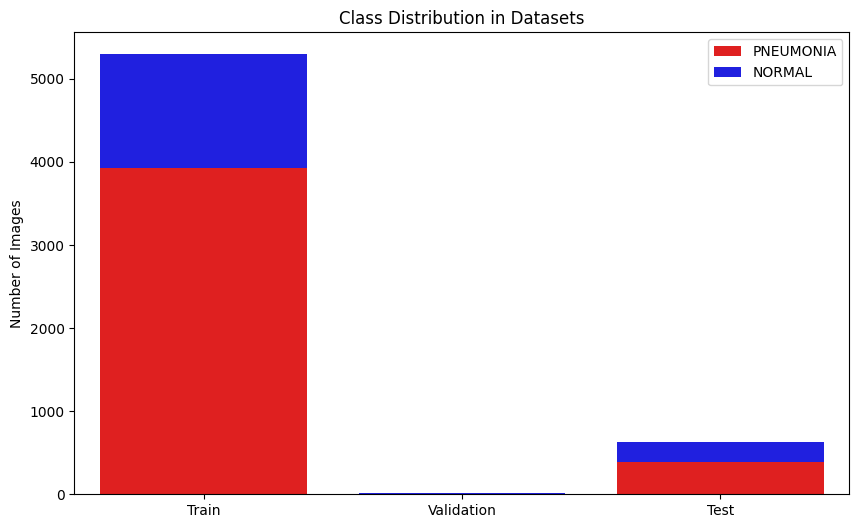

In [ ]:
def count_images(directory):
    pneumonia_count = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    normal_count = len(os.listdir(os.path.join(directory, 'NORMAL')))
    return pneumonia_count, normal_count

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

datasets = ['Train', 'Validation', 'Test']
pneumonia = [train_counts[0], val_counts[0], test_counts[0]]
normal = [train_counts[1], val_counts[1], test_counts[1]]

# Plot distribution
plt.figure(figsize=(10,6))
sns.barplot(x=datasets, y=pneumonia, color='red', label='PNEUMONIA')
sns.barplot(x=datasets, y=normal, bottom=pneumonia, color='blue', label='NORMAL')
plt.legend()
plt.title('Class Distribution in Datasets')
plt.ylabel('Number of Images')
plt.show()


In [ ]:
IMG_SIZE = 299

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5293 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


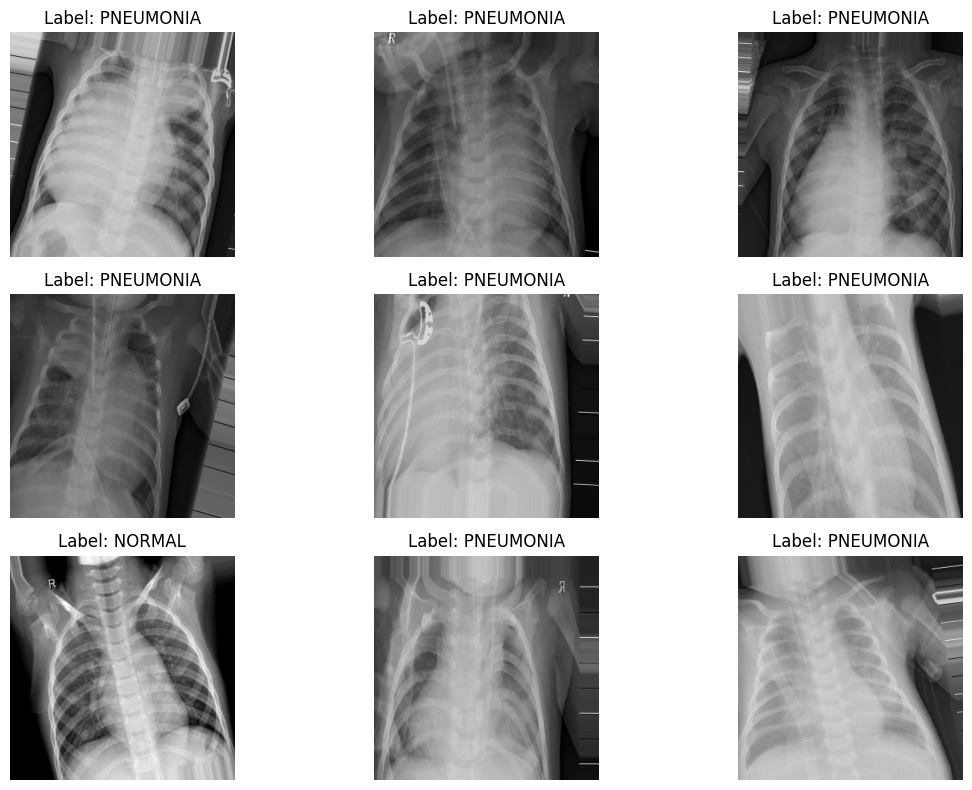

In [ ]:
# Display some augmented training images
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Label: ' + ('PNEUMONIA' if sample_labels[i] else 'NORMAL'))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base layers
base_model.trainable = False

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Define the model
inception_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
inception_model.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Model summary
inception_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,073,889 (84.21 MB)

 Trainable params: 266,753 (1.02 MB)

 Non-trainable params: 21,807,136 (83.19 MB)

In [ ]:
early_stop_incep = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint_incep = ModelCheckpoint('InceptionV3_Pneumonia.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)


In [ ]:
history_incep = inception_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop_incep, checkpoint_incep]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7205 - loss: 0.6197
Epoch 1: val_loss improved from inf to 0.39128, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 768s 5s/step - accuracy: 0.7210 - loss: 0.6188 - val_accuracy: 0.8125 - val_loss: 0.3913
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8807 - loss: 0.3157
Epoch 2: val_loss improved from 0.39128 to 0.29393, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.8807 - loss: 0.3156 - val_accuracy: 0.8750 - val_loss: 0.2939
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9215 - loss: 0.2553
Epoch 3: val_loss did not improve from 0.29393
166/166 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9214 - loss: 0.2553 - val_accuracy: 0.7500 - val_loss: 0.3483
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9200 - loss: 0.2394
Epoch 4: val_loss improved from 0.29393 to 0.28868, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9200 - loss: 0.2393 - val_accuracy: 0.8125 - val_loss: 0.2887
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9320 - loss: 0.2106
Epoch 5: val_loss did not improve from 0.28868
166/166 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9320 - loss: 0.2105 - val_accuracy: 0.8125 - val_loss: 0.3120
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9446 - loss: 0.1966
Epoch 6: val_loss did not improve from 0.28868
166/166 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9445 - loss: 0.1965 - val_accuracy: 0.8125 - val_loss: 0.3738
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9387 - loss: 0.1878
Epoch 7: val_loss did not improve from 0.28868
166/166 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9387 - loss: 0.1877 - val_accuracy: 0.8750 - val_loss: 0.4223
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9459 - loss: 0.1701
Epoch 8: val_loss did not improve from 0.28868


In [ ]:
base_model.trainable = True

# Compile again with lower learning rate
inception_model.compile(optimizer=Adam(learning_rate=1e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Fine-tune training
fine_tune_incep = inception_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop_incep, checkpoint_incep]
)


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8141 - loss: 0.4350
Epoch 1: val_loss did not improve from 0.28868
166/166 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.8144 - loss: 0.4346 - val_accuracy: 0.6875 - val_loss: 0.6862
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9260 - loss: 0.2339
Epoch 2: val_loss did not improve from 0.28868
166/166 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9260 - loss: 0.2338 - val_accuracy: 0.6875 - val_loss: 1.0715
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9435 - loss: 0.1638
Epoch 3: val_loss did not improve from 0.28868
166/166 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9435 - loss: 0.1638 - val_accuracy: 0.6875 - val_loss: 0.6989
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9513 - loss: 0.1549
Epoch 4: val_loss improved from 0.28868 to 0.22288, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9514 - loss: 0.1548 - val_accuracy: 0.8750 - val_loss: 0.2229
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9718 - loss: 0.1059
Epoch 5: val_loss improved from 0.22288 to 0.21017, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9718 - loss: 0.1060 - val_accuracy: 0.8750 - val_loss: 0.2102
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9716 - loss: 0.0943
Epoch 6: val_loss did not improve from 0.21017
166/166 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9716 - loss: 0.0943 - val_accuracy: 0.8125 - val_loss: 0.2334
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9748 - loss: 0.0832
Epoch 7: val_loss improved from 0.21017 to 0.17880, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9748 - loss: 0.0831 - val_accuracy: 0.9375 - val_loss: 0.1788
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9709 - loss: 0.0984
Epoch 8: val_loss improved from 0.17880 to 0.12971, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9709 - loss: 0.0984 - val_accuracy: 0.9375 - val_loss: 0.1297
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9782 - loss: 0.0714
Epoch 9: val_loss did not improve from 0.12971
166/166 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9782 - loss: 0.0714 - val_accuracy: 0.9375 - val_loss: 0.1357
Epoch 10/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9736 - loss: 0.0817
Epoch 10: val_loss improved from 0.12971 to 0.08250, saving model to InceptionV3_Pneumonia.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.9736 - loss: 0.0817 - val_accuracy: 1.0000 - val_loss: 0.0825


In [ ]:
test_loss_incep, test_accuracy_incep = inception_model.evaluate(test_generator)
print(f"InceptionV3 Test Accuracy: {test_accuracy_incep * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 216s 11s/step - accuracy: 0.8579 - loss: 0.3705
InceptionV3 Test Accuracy: 90.38%


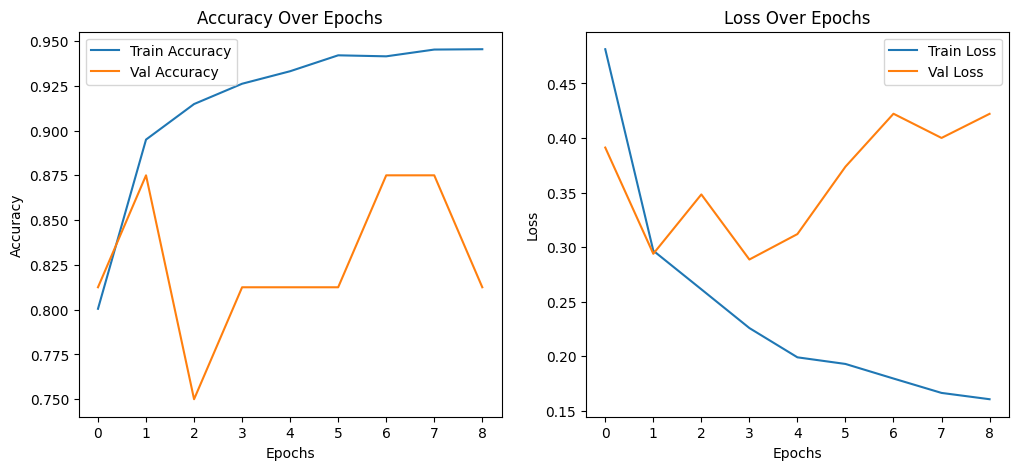

In [ ]:
def plot_history(histories):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(histories.history['accuracy'], label='Train Accuracy')
    plt.plot(histories.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(histories.history['loss'], label='Train Loss')
    plt.plot(histories.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_incep)

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 781ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.79      0.86       234
   PNEUMONIA       0.88      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



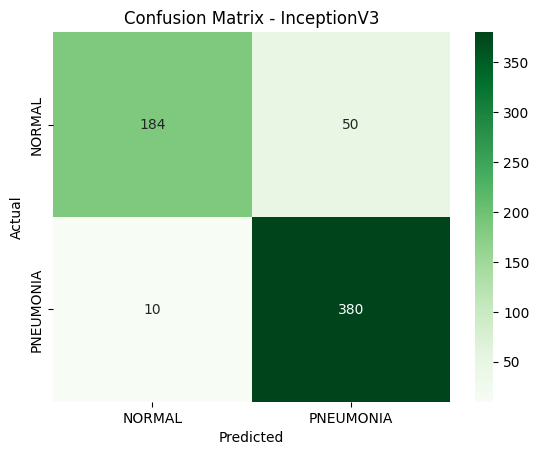

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_true_incep = test_generator.classes
y_pred_probs_incep = inception_model.predict(test_generator)
y_pred_incep = (y_pred_probs_incep > 0.5).astype(int)

# Report
print(classification_report(y_true_incep, y_pred_incep, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion Matrix
cm_incep = confusion_matrix(y_true_incep, y_pred_incep)
sns.heatmap(cm_incep, annot=True, fmt='d', cmap='Greens', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - InceptionV3')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = array / 255.0
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


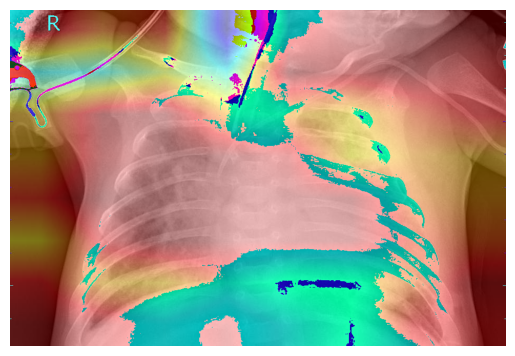

In [ ]:
# Example paths (replace with actual paths in your drive)
img_path_normal = '/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0005-0001.jpeg'
img_path_pneumonia = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'

# Preprocess image
img_array = get_img_array(img_path_pneumonia, size=(299, 299))

# Get Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, inception_model, last_conv_layer_name='mixed10')  # Last conv layer in InceptionV3

# Display Grad-CAM
display_gradcam(img_path_pneumonia, heatmap)


In [ ]:
# Define path with correct extension
model_save_path = "/content/drive/MyDrive/inception_model.keras"

# Save the model
inception_model.save(model_save_path)

print(f"Model saved at {model_save_path}")


Model saved at /content/drive/MyDrive/inception_model.keras
